In [ ]:
pip install catboost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import os
import random
from sklearn.preprocessing import LabelEncoder

# ML
from sklearn.ensemble import RandomForestClassifier  # Bagging
from xgboost.sklearn import XGBClassifier            # GBM
from sklearn.linear_model import LogisticRegression  # LogisticRegression
from sklearn.svm import SVC                          # SVM
from catboost import CatBoostClassifier as cat       # Catboost
from lightgbm import LGBMClassifier as lgb           # LGBM


# DL
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, ReLU, Softmax, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# for checking multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : for optuna
from sklearn.model_selection import KFold, StratifiedKFold
from functools import partial

# AutoML framework
import optuna

In [2]:
# set configs
is_tuning = True
is_scaling = True
is_pca = False
if is_tuning:
    n_trials=50
    
# Keras model compile
learning_rate = 1e-3
batch_size = 64
epochs = 10

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything()

In [40]:
def balance_logloss(y_true, y_pred):
#     y_pred = tf.clip_by_value(y_pred, 1e-15, 1-1e-15)
#     y_pred /= tf.reduce_sum(y_pred, axis=1, keepdims=True)
#     nc = tf.math.bincount(tf.cast(y_true, tf.int32))
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    y_pred = y_pred.reshape(-1, 1)
    y_pred /= np.sum(y_pred, axis=1)[:, None]
    nc = np.bincount(y_true)
  
#     if tf.shape(nc)[0] == 1:
#         return tf.constant(float('nan'))
#     elif tf.shape(nc)[0] == 2:
#         logloss = (-1 / nc[0] * (tf.reduc_sum(tf.where(y_true == 0, 1, 0) * tf.math.log(y_pred[:, 0])))
#                    - 1 / nc[1] * (tf.reduce_sum(tf.where(y_true != 0, 1, 0) * tf.math.log(y_pred[:, 1])))) / 2
#         return logloss
        
    
    if len(nc) == 1:
        return np.nan
    elif len(nc) == 2:
        logloss = (-1 / nc[0] * (np.sum(np.where(y_true == 0, 1, 0) * np.log(y_pred[:, 0])))
                   - 1 / nc[1] * (np.sum(np.where(y_true != 0, 1, 0) * np.log(y_pred[:, 1])))) / 2
        return logloss
    else:
        raise ValueError("Expected two classes in y_true.")


# def balance_loglossv2(y_true, y_pred):
#     from sklearn.metrics import log_loss
    
#     target_mean = y_true.mean()
#     w0 = 1/(1-target_mean)
#     w1 = 1/target_mean
#     sample_weight = [w0 if y == 0 else w1 for y in y_true]
#     loss = log_loss(y_true, y_pred, sample_weight=sample_weight)
    
#     return loss

def b_logloss_keras(y_true, y_pred):
    y_true = y_true[:, 1] * (1 - y_true[:, 0])
    y_true = tf.cast(y_true, tf.int64)
    score = tf.py_function(func=balance_logloss, inp=[y_true, y_pred], Tout=tf.float32)
    return score


In [5]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
greeks = pd.read_csv('./greeks.csv')
submission = pd.read_csv('./sample_submission.csv')

In [6]:
train_no_class = train.drop(columns='Class')
train_no_class

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,9.879296,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.910227,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,12.029366,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,8.026928,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622


In [7]:
greeks_cleanse = greeks.drop(columns='Epsilon').T
greeks_cleanse

,0,1,2,3,4,5,6,7,8,9,...,607,608,609,610,611,612,613,614,615,616
Id,000ff2bfdfe9,007255e47698,013f2bd269f5,043ac50845d5,044fb8a146ec,04517a3c90bd,049232ca8356,057287f2da6d,0594b00fb30a,05f2bc0155cd,...,fb786fb02a65,fbb79ba9d642,fbc241daef00,fbd12c4ae88b,fd1dd68d51b4,fd3dafe738fd,fd895603f071,fd8ef6377f76,fe1942975e40,ffcca4ded3bb
Alpha,B,A,A,A,D,A,A,A,A,A,...,A,B,A,A,A,A,A,A,A,A
Beta,C,C,C,C,B,C,C,C,C,B,...,C,C,B,C,B,B,B,C,C,C
Gamma,G,M,M,M,F,M,M,M,M,M,...,M,H,M,M,M,M,M,M,M,M
Delta,D,B,B,B,B,B,B,B,B,B,...,B,B,B,C,B,B,B,B,B,B


In [8]:
TEMP_FINAL_LIST = []
for i in range(len(greeks_cleanse.T)):
    temp = []

    for value in greeks_cleanse[i]:
        if len(value) > 1:
            continue
        else:
            temp.append(value)
    temp = "".join(temp)
    TEMP_FINAL_LIST.append(temp)
    
temp_df = pd.DataFrame(TEMP_FINAL_LIST)

temp_df.columns = ['Merged']

In [9]:
label_encoder = LabelEncoder()
temp_df = label_encoder.fit_transform(temp_df['Merged'])
meta_encoded = pd.DataFrame(temp_df)
meta_encoded.columns = ['greeks_labeled']


In [10]:
meta_encoded

,greeks_labeled
0,11
1,2
2,2
3,2
4,19
...,...
612,1
613,1
614,2
615,2


greeks_for_label_encoding = greeks.drop(columns=['Id', 'Epsilon'])
for idx in greeks_for_label_encoding:
    greeks_for_label_encoding[idx] = label_encoder.fit_transform(greeks_for_label_encoding[idx])

train_test_2 = pd.concat([train_no_class, greeks_for_label_encoding], axis=1)
train_test_2 = pd.concat([train_test_2, train['Class']], axis=1)
train_test_2

In [11]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train.EJ = lb.fit_transform(train.EJ)  # A->0, B->1

train_make = train.drop(columns=["Id"])

In [12]:
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=5)
data = imp.fit_transform(train_make)
train = pd.DataFrame(columns=train_make.columns,
                    data=data)
train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1.0
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0.0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0.0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0.0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0.0
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0.0
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0.0
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0.0


In [13]:
[variance_inflation_factor(train, i) for i in range (train.shape[1])]

[7.2095739993551575,
 5.470538251819652,
 11.585741146057817,
 2.786878254443682,
 14.540495225807067,
 10.228085450648146,
 2.526156690473772,
 9.966742100413436,
 9.938931175170422,
 23.227993233946783,
 48.06760490475717,
 4.1388138645341845,
 3.4383694814886123,
 1.2403515373222145,
 8.946707585429914,
 1.479249679578719,
 13.683901431598526,
 7.16315467623831,
 3.1093321570638612,
 20.53530663791221,
 17.96706987015737,
 11.037863968893861,
 24.22647818878248,
 13.220745704979937,
 5.291024055996091,
 11.731331611676834,
 3.1850487770314944,
 1.9149249477005985,
 19.574883762985156,
 8.295421294871216,
 17.863211260857867,
 19.66355500068502,
 5.338229961461866,
 50.46644497330504,
 3.912479740208057,
 13.312838778592633,
 4.761066975281217,
 2.1694803585135336,
 29.6969369322989,
 42.95100193888579,
 5.877152122667336,
 17.80985987647956,
 1.5014021819363317,
 1.7144306439608445,
 23.74701805830803,
 2.2656774598132055,
 19.600839110286543,
 3.075277608165649,
 1.0510801038942414

In [14]:
def check_vif(df):
    vifs = [variance_inflation_factor(df, i) for i in range(df.shape[1])]
    vif_df = pd.DataFrame({"features":df.columns, "VIF" : vifs})
    vif_df = vif_df.sort_values(by="VIF", ascending=False)
    remove_col = vif_df.iloc[0, 0]
    top_vif = vif_df.iloc[0, 1]
    return vif_df, remove_col, top_vif

In [15]:
# remove all features when VIF is over 10.
top_vif = 100

while(top_vif > 5):
    vif_df, remove_col, top_vif = check_vif(train)
    print(remove_col, top_vif)
    if top_vif < 5:
        break
    train = train.drop(columns=remove_col)

train

DV 50.46644497330504
BN 48.06110826582044
EJ 32.6367510740489
EH 29.40635981278969
CS 24.144938821759094
BD  20.702906700992884
CH 19.316810821354846
DH 18.654502700291943
FI 17.585104766962257
DN 17.042317022730487
DL 16.010536364722082
GH 13.074318172560375
AR 12.852344213058096
CC 12.038919689965544
EB 11.810459819290948
AX 9.892706105085827
CU 9.028395892384713
AZ 8.919414904629303
DA 8.58855056939777
CR 7.954673012680349
BZ 7.6867848986619425
EP 7.525379762629327
GB 7.083289130542604
DI 6.770878103410761
AH 5.44579794497443
AB 5.325827432481412
EL 5.112489497216353
CD  4.6443713088361624


,AF,AM,AY,BC,BP,BQ,BR,CB,CD,CF,...,FD,FE,FL,FR,FS,GE,GF,GI,GL,Class
0,3109.03329,22.394407,0.025578,5.555634,175.638726,152.707705,823.928241,47.223358,23.387600,4.851915,...,10.265073,9028.291921,7.298162,1.73855,0.094822,72.611063,2003.810319,69.834944,0.120343,1.0
1,978.76416,36.968889,0.025578,1.229900,155.868030,14.754720,51.216883,30.284345,50.628208,6.085041,...,0.296850,6785.003474,0.173229,0.49706,0.568932,72.611063,27981.562750,32.131996,21.978000,0.0
2,2635.10654,32.360553,0.025578,1.229900,128.988531,219.320160,482.141594,32.563713,85.955376,5.376488,...,8.745201,8338.906181,7.709560,0.97556,1.198821,88.609437,13676.957810,35.192676,0.196941,0.0
3,3819.65177,77.112203,0.025578,1.229900,237.282264,11.050410,661.518640,15.201914,88.159360,2.347652,...,7.884336,10965.766040,6.122162,0.49706,0.284466,82.416803,2094.262452,90.493248,0.155829,0.0
4,3733.04844,14.103738,0.054810,102.151980,324.546318,149.717165,6074.859475,82.213495,72.644264,30.537722,...,4.274640,16198.049590,8.153058,48.50134,0.121914,146.109943,8524.370502,36.262628,0.096614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,3130.05946,9.513984,0.077343,2.804172,167.877117,27.287375,365.516874,41.368691,55.163024,4.780452,...,0.296850,17167.209610,0.173229,1.26092,0.067730,217.148554,8095.932828,69.191944,21.978000,0.0
613,5462.03438,46.551007,0.025882,3.777550,285.628059,344.644105,505.006814,61.910576,85.233928,6.682597,...,6.067614,18460.330020,10.223150,1.24236,0.426699,496.994214,3085.308063,124.808872,0.145340,0.0
614,2459.10720,55.355778,0.025578,1.229900,178.661133,103.988995,2083.880500,90.411867,142.680216,7.809288,...,0.296850,5088.922912,0.173229,0.49706,0.067730,128.896894,6474.652866,119.559420,21.978000,0.0
615,1263.53524,23.685856,0.025578,1.229900,119.162529,82.512333,722.377629,12.499760,122.939496,2.964975,...,6.192291,6464.250832,9.256996,0.78764,0.670527,72.611063,1965.343176,37.155112,0.184622,0.0


In [16]:
train_test_1 = pd.concat([train.drop(columns='Class'), meta_encoded], axis=1)
train = pd.concat([train_test_1, train['Class']], axis=1)
train

,AF,AM,AY,BC,BP,BQ,BR,CB,CD,CF,...,FE,FL,FR,FS,GE,GF,GI,GL,greeks_labeled,Class
0,3109.03329,22.394407,0.025578,5.555634,175.638726,152.707705,823.928241,47.223358,23.387600,4.851915,...,9028.291921,7.298162,1.73855,0.094822,72.611063,2003.810319,69.834944,0.120343,11,1.0
1,978.76416,36.968889,0.025578,1.229900,155.868030,14.754720,51.216883,30.284345,50.628208,6.085041,...,6785.003474,0.173229,0.49706,0.568932,72.611063,27981.562750,32.131996,21.978000,2,0.0
2,2635.10654,32.360553,0.025578,1.229900,128.988531,219.320160,482.141594,32.563713,85.955376,5.376488,...,8338.906181,7.709560,0.97556,1.198821,88.609437,13676.957810,35.192676,0.196941,2,0.0
3,3819.65177,77.112203,0.025578,1.229900,237.282264,11.050410,661.518640,15.201914,88.159360,2.347652,...,10965.766040,6.122162,0.49706,0.284466,82.416803,2094.262452,90.493248,0.155829,2,0.0
4,3733.04844,14.103738,0.054810,102.151980,324.546318,149.717165,6074.859475,82.213495,72.644264,30.537722,...,16198.049590,8.153058,48.50134,0.121914,146.109943,8524.370502,36.262628,0.096614,19,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,3130.05946,9.513984,0.077343,2.804172,167.877117,27.287375,365.516874,41.368691,55.163024,4.780452,...,17167.209610,0.173229,1.26092,0.067730,217.148554,8095.932828,69.191944,21.978000,1,0.0
613,5462.03438,46.551007,0.025882,3.777550,285.628059,344.644105,505.006814,61.910576,85.233928,6.682597,...,18460.330020,10.223150,1.24236,0.426699,496.994214,3085.308063,124.808872,0.145340,1,0.0
614,2459.10720,55.355778,0.025578,1.229900,178.661133,103.988995,2083.880500,90.411867,142.680216,7.809288,...,5088.922912,0.173229,0.49706,0.067730,128.896894,6474.652866,119.559420,21.978000,2,0.0
615,1263.53524,23.685856,0.025578,1.229900,119.162529,82.512333,722.377629,12.499760,122.939496,2.964975,...,6464.250832,9.256996,0.78764,0.670527,72.611063,1965.343176,37.155112,0.184622,2,0.0


<Axes: >

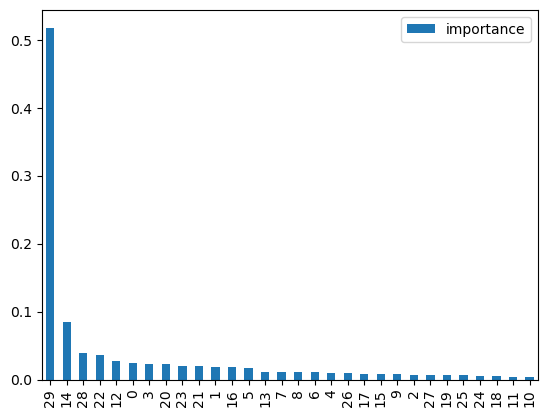

In [17]:
# feature selection via Feature Importance
X = train.drop(columns=['Class'])
y = train['Class']

rf = RandomForestClassifier()
rf.fit(X, y)
# [(col, fi) for col, fi in zip(X.columns, rf.feature_importances_)]
fi_df = pd.DataFrame({'feature': X.columns, 'importance' : rf.feature_importances_})

fi_df.sort_values(by='importance', ascending=False).plot(kind='bar')

In [19]:
# featrue 고름

selected_cols = fi_df.sort_values(by='importance', ascending=False)[:10]['feature'].values
selected_cols

array(['greeks_labeled', 'DU', 'GL', 'FL', 'DE', 'AF', 'BC', 'FD ', 'FR',
       'FE'], dtype=object)

In [20]:
# class imbalance handling

## 1. undersampling
c1 = train[train.Class==1]
c0 = train[train.Class==0]

print(c1.shape, c0.shape)
c0 = c0.sample(n=c1.shape[0])
train = pd.concat([c0, c1])
train.shape

(108, 31) (509, 31)


(216, 31)

In [21]:
X = train.drop(columns = ['Class'])
y = train['Class']

##### Oversampling


df = train[selected_cols]
df['Class'] = train['Class']
pd.pivot_table(index='Class', data=df)

## 2. oversampling = SMOTE
from imblearn.over_sampling import SMOTE

X = train[selected_cols]
y = train['Class']

smote = SMOTE(k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(X_resampled.shape, y_resampled.shape)

## 3. hybrid approach

## class0 : 509 -> 300
## class1 : 108 -> 300

# class imbalance handling
## 1. undersampling

if sampling_method == 'hybrid':
    N = 300
    c1 = train[train.Class == 1]
    c0 = train[train.Class == 0]
    print(c1.shape, c0.shape)
    c0 = c0.sample(n=N)
    


df = X_resampled.copy()
df['Class'] = y_resampled
pd.pivot_table(index='Class', data=df)

X = X_resampled
y = y_resampled

In [22]:
# to make OOF prediction
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(183, 30) (33, 30) (183,) (33,)


##### Feature Scailing

In [23]:
from sklearn.preprocessing import StandardScaler

if is_scaling:
    scaler = StandardScaler()
    data_ = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(data=data_, columns=X_train.columns)
    data_ = scaler.transform(X_val)
    X_val = pd.DataFrame(data=data_, columns=X_val.columns)
    display(X_train)

,AF,AM,AY,BC,BP,BQ,BR,CB,CD,CF,...,FD,FE,FL,FR,FS,GE,GF,GI,GL,greeks_labeled
0,-1.252596,-0.366028,-0.100592,-0.152155,-0.621232,-1.107102,-0.108624,-0.339861,-0.678668,-0.333418,...,-0.108240,-0.618327,-0.178877,-0.095048,-0.762021,-0.118682,-0.706198,-1.251161,-0.721583,-0.808371
1,-0.117621,-0.353668,-0.070145,-0.152155,1.470145,-0.557862,-0.110309,-0.306822,0.248467,-0.261646,...,-0.132366,-0.367834,-0.533679,-0.087827,-0.668317,1.761972,-0.157587,1.133209,1.459620,-0.932267
2,-0.397176,-0.142088,-0.100592,-0.092919,-0.209365,-0.820277,-0.107484,4.716102,0.919498,-0.083984,...,-0.132366,-0.109861,-0.533679,-0.088592,0.409275,-0.393364,1.441697,-1.126268,1.459620,-0.808371
3,-0.504276,-0.197202,-0.100592,-0.122596,-0.373858,-0.968494,0.009293,-0.143237,0.782902,-0.092760,...,-0.116935,-0.418057,-0.496279,-0.094868,-0.637083,-0.393364,-0.629788,-0.809423,-0.021642,-0.808371
4,-0.116977,-0.052274,-0.100592,-0.134059,-0.167656,-0.963180,-0.097013,-0.198098,-0.608757,-0.339364,...,0.012842,-0.638123,-0.028440,-0.086747,2.267732,-0.393364,1.780440,-0.217927,-0.705577,-0.808371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,-0.430262,-0.330647,-0.100592,-0.105181,-0.099251,-0.601638,-0.076778,-0.088759,-0.190602,-0.038259,...,-0.072302,-0.308643,0.127586,-0.079488,1.611806,-0.393364,0.295882,-0.429885,-0.725154,0.554486
179,-0.135461,-0.333879,-0.100592,-0.144603,0.257750,-0.875822,-0.041366,-0.162292,-0.564181,-0.163755,...,-0.092206,-0.053598,-0.333869,-0.096072,0.081312,1.319480,-0.353198,1.193366,-0.650212,-0.932267
180,0.568318,-0.232129,-0.100592,-0.087706,-0.445526,-0.192026,-0.072077,-0.339861,-0.254777,-0.106563,...,-0.132366,3.579011,-0.533679,-0.096072,-0.762021,-0.393364,-0.058297,-0.745040,1.459620,1.793446
181,0.889754,3.101485,-0.100592,-0.152155,-0.266279,-0.179771,-0.142152,-0.331947,-0.408941,-0.348707,...,-0.131562,0.484409,1.105255,-0.085411,2.580077,-0.393364,-0.452571,3.391842,-0.732516,0.058901


In [24]:
if is_pca:
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=0.80, random_state=42)
    data_ = pca.fit_transform(X_train)
    X_train = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])
    data_ = pca.transform(X_val)
    X_val = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])

    display(X_train)

In [25]:
# Model ensemble of SVM, Logistic Regression, XGBoost, RandomForest, Simple NN.

svm = SVC(random_state=42)
lr = LogisticRegression(random_state=42, max_iter=300)
xgb = XGBClassifier(max_depth=3, colsample_bytree=0.8, reg_lambda=1, objective='binary:logistic', random_state=42)
rf = RandomForestClassifier(max_depth=3, max_features=0.8, criterion='log_loss', random_state=42)
catb = cat(iterations=300, depth=3, od_type='Iter', od_wait=15, bootstrap_type='Bayesian', random_state=42)
lgbm = lgb(boosting_type='gbdt', min_child_samples=20, min_child_weight=0.001, n_estimators=20, random_state=42)

nn = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(30), ReLU(), Dropout(0.2),
    Dense(20), ReLU(), Dropout(0.2),
    Dense(10), ReLU(), Dropout(0.1),
    Dense(5), ReLU(), Dropout(0.2),
    Dense(5), ReLU(), Dropout(0.2),
    Dense(2), Softmax()
])
nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 re_lu (ReLU)                (None, 30)                0         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 re_lu_1 (ReLU)              (None, 20)                0         
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [35]:
optimizer = Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.8)   # [0.8, 0.2] <--> [0.9, 0] // [0, 0.9]
scheduler = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=10,
                              min_lr=1e-6)
earlystopper = EarlyStopping(monitor='val_loss',
                             patience=20,
                             min_delta=1e-2)


nn.compile(optimizer=optimizer, loss=loss_fn, metrics=[b_logloss_keras])

nn_y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
nn_y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [36]:
print("\nFitting LogisticRegression...")
lr.fit(X_train, y_train)
print("\nFitting SVM...")
svm.fit(X_train, y_train)
print("\nFitting RandomForest...")
rf.fit(X_train, y_train)
print("\nFitting XGBoost...")
xgb.fit(X_train, y_train)
print("\nFitting CatBoost...")
catb.fit(X_train, y_train)
print("\nFitting Light GBM...")
lgbm.fit(X_train, y_train)
print("\nFitting MLP...")
history = nn.fit(X_train, nn_y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=[X_val, nn_y_val],
                callbacks=[scheduler, earlystopper])


Fitting LogisticRegression...

Fitting SVM...

Fitting RandomForest...

Fitting XGBoost...

Fitting CatBoost...
Learning rate set to 0.015048
0:	learn: 0.6604049	total: 682us	remaining: 204ms
1:	learn: 0.6325064	total: 1.58ms	remaining: 236ms
2:	learn: 0.6123846	total: 2.4ms	remaining: 238ms
3:	learn: 0.5869539	total: 2.96ms	remaining: 219ms
4:	learn: 0.5612997	total: 3.54ms	remaining: 209ms
5:	learn: 0.5386461	total: 4.08ms	remaining: 200ms
6:	learn: 0.5132830	total: 4.63ms	remaining: 194ms
7:	learn: 0.4880770	total: 5.16ms	remaining: 188ms
8:	learn: 0.4692198	total: 5.57ms	remaining: 180ms
9:	learn: 0.4545128	total: 6.26ms	remaining: 181ms
10:	learn: 0.4342132	total: 6.85ms	remaining: 180ms
11:	learn: 0.4179094	total: 7.43ms	remaining: 178ms
12:	learn: 0.4000218	total: 7.79ms	remaining: 172ms
13:	learn: 0.3809425	total: 8.15ms	remaining: 167ms
14:	learn: 0.3628931	total: 8.55ms	remaining: 163ms
15:	learn: 0.3483508	total: 8.92ms	remaining: 158ms
16:	learn: 0.3342985	total: 9.31ms	re

3/3 [==============================] - 0s 69ms/step - loss: 0.7234 - b_logloss_keras: 0.7483 - val_loss: 0.6968 - val_b_logloss_keras: 0.7071 - lr: 0.0010
Epoch 2/10
3/3 [==============================] - 0s 10ms/step - loss: 0.7146 - b_logloss_keras: 0.7291 - val_loss: 0.6948 - val_b_logloss_keras: 0.6988 - lr: 0.0010
Epoch 3/10
3/3 [==============================] - 0s 13ms/step - loss: 0.7124 - b_logloss_keras: 0.7260 - val_loss: 0.6939 - val_b_logloss_keras: 0.6942 - lr: 0.0010
Epoch 4/10
3/3 [==============================] - 0s 12ms/step - loss: 0.7249 - b_logloss_keras: 0.7565 - val_loss: 0.6937 - val_b_logloss_keras: 0.6929 - lr: 0.0010
Epoch 5/10
3/3 [==============================] - 0s 13ms/step - loss: 0.7077 - b_logloss_keras: 0.7259 - val_loss: 0.6937 - val_b_logloss_keras: 0.6935 - lr: 0.0010
Epoch 6/10
3/3 [==============================] - 0s 11ms/step - loss: 0.7166 - b_logloss_keras: 0.7400 - val_loss: 0.6937 - val_b_logloss_keras: 0.6942 - lr: 0.0010
Epoch 7/10
3/3 

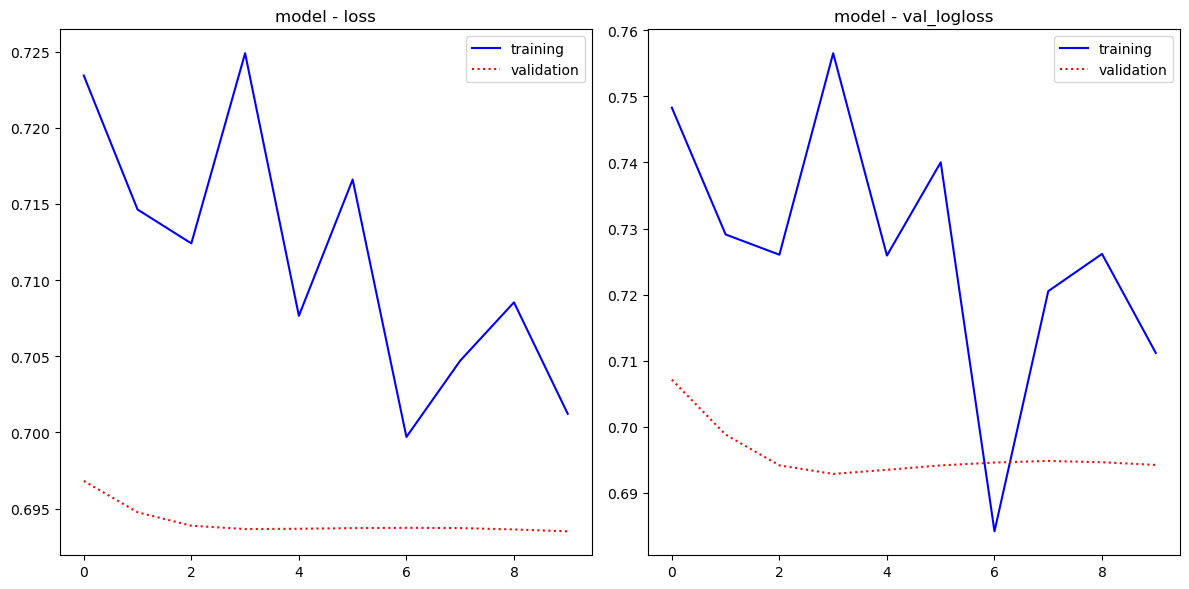

In [37]:
## loss visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(history.history['loss'],'b-', label = "training")
plt.plot(history.history['val_loss'], 'r:', label = "validation")
plt.title("model - loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("model - val_logloss")

plt.plot(history.history['b_logloss_keras'], 'b-', label = "training")
plt.plot(history.history['val_b_logloss_keras'], 'r:', label = "validation")

plt.legend()
plt.tight_layout()
plt.show()

In [38]:
# set metric
evaluation_metric = balance_logloss
evaluation_metric_keras = b_logloss_keras

In [41]:
print("--- Prediction with LR ---")
lr_pred_train = lr.predict_proba(X_train)
lr_pred_val = lr.predict_proba(X_val)

lr_train_score = evaluation_metric(y_train, lr_pred_train)
lr_val_score = evaluation_metric(y_val, lr_pred_val)

print("Train Score : %.4f" % lr_train_score)
print("Test Score : %.4f" % lr_val_score)

print("--- Prediction with SVM ---")
svm_pred_train = svm.predict(X_train)
svm_pred_val = svm.predict(X_val)

svm_train_score = evaluation_metric(y_train, svm_pred_train)
svm_val_score = evaluation_metric(y_val, svm_pred_val)

print("Train Score : %.4f" % svm_train_score)
print("Test Score : %.4f" % svm_val_score)

print("--- Prediction with RF ---")
rf_pred_train = rf.predict_proba(X_train)
rf_pred_val = rf.predict_proba(X_val)

rf_train_score = evaluation_metric(y_train, rf_pred_train)
rf_val_score = evaluation_metric(y_val, rf_pred_val)

print("Train Score : %.4f" % rf_train_score)
print("Test Score : %.4f" % rf_val_score)

print("--- Prediction with CAT ---")
cat_pred_train = catb.predict_proba(X_train)
cat_pred_val = catb.predict_proba(X_val)

cat_train_score = evaluation_metric(y_train, cat_pred_train)
cat_val_score = evaluation_metric(y_val, cat_pred_val)

print("Train Score : %.4f" % cat_train_score)
print("Test Score : %.4f" % cat_val_score)

print("--- Prediction with LGBM ---")
lgb_pred_train = lgbm.predict_proba(X_train)
lgb_pred_val = lgbm.predict_proba(X_val)

lgb_train_score = evaluation_metric(y_train, lgb_pred_train)
lgb_val_score = evaluation_metric(y_val, lgb_pred_val)

print("Train Score : %.4f" % lgb_train_score)
print("Test Score : %.4f" % lgb_val_score)

print("--- Prediction with MLP ---")
pred_train = nn.predict(X_train)
pred_val = nn.predict(X_val)

train_score = evaluation_metric_keras(nn_y_train, pred_train)
val_score = evaluation_metric_keras(nn_y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Validation Score : %.4f" % val_score)

--- Prediction with LR ---
Train Score : 0.0527
Test Score : 0.1101
--- Prediction with SVM ---


ValueError: cannot reshape array of size 183 into shape (2)

In [42]:
def rf_optimizer(trial, X, y, K):
    # define parameter to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    max_features = trial.suggest_float('max_features', 0.6, 0.8, log=True)
    
    
    # set model
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   max_features=max_features,
                                   criterion='log_loss',
                                   class_weight='balanced'
                                  )
    
    # K-Fold Cross validation
    folds = StratifiedKFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    # return mean score of CV
    return np.mean(losses)

In [43]:
def svm_optimizer(trial, X, y, K):
    C = trial.suggest_int('C', 1, 100)
    kernel = trial.suggest_categorical('kernel', ['rbf'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    

    model = SVC(C=C,
                kernel=kernel,
                class_weight='balanced', # if class imbalanced
                gamma=gamma,
                probability=True,
                cache_size=1000,
                random_state=42
               )
    
    folds = StratifiedKFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    return np.mean(losses)

In [44]:
def lr_optimizer(trial, X, y, K):

    C = trial.suggest_int('C', 5, 100)
    solver = trial.suggest_categorical('solver', ['liblinear', 'newton-cg', 'newton-cholesky', 'saga'])    
    

    model = LogisticRegression(C=C,
                               solver=solver,
                               max_iter=500,
                               class_weight='balanced',
                               random_state=42,
                               n_jobs=-1)
    
    
    folds = StratifiedKFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    return np.mean(losses)

In [45]:
def xgb_optimizer(trial, X, y, K):
    n_estimators = trial.suggest_int('n_estimators', 50, 2000)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.8, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 0.1, 2, log=True)
    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    
    
    model = XGBClassifier(n_estimators=n_estimators,
                          max_depth=max_depth,
                          booster=booster,
                          colsample_bytree=colsample_bytree,
                          learning_rate=learning_rate,
                          reg_lambda=reg_lambda,
                          scale_pos_weight=4.71)
    
    
    folds = StratifiedKFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    return np.mean(losses)

In [46]:
def cat_optimizer(trial, X, y, K):
    iterations = trial.suggest_int('iterations', 50, 200)
    depth = trial.suggest_int('depth', 4, 16)
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian'])
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True)
#     random_strength = trial.suggest_float('random_strength', 1e-8, 10.0, log=True)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0, 10, log=False)
#     od_type = trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
#     od_wait = trial.suggest_int('od_wait', 10, 50)
    
    
    model = cat(iterations=iterations,
                depth=depth,
                bootstrap_type=bootstrap_type,
                l2_leaf_reg=l2_leaf_reg,
#                 random_strength=random_strength,
                learning_rate=learning_rate,
                bagging_temperature=bagging_temperature,
#                 od_type=od_type,
#                 od_wait=od_wait,
#                 verbose=False,
                random_state=42
               )
    
    
    folds = StratifiedKFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    return np.mean(losses)

In [47]:
def lgbm_optimizer(trial, X, y, K):
    num_leaves = trial.suggest_int('num_leaves', 100, 500)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    
    
    model = lgb(max_depth=max_depth,
                application='binary',
                metric='binary_logloss',
                num_leaves=num_leaves,
                boosting_type=boosting_type,
                learning_rate=learning_rate,
                random_state=42
               )
    
    
    folds = StratifiedKFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    return np.mean(losses)

In [48]:
K = 6 # set K of K-Fold
opt_func = partial(rf_optimizer, X=X_train, y=y_train, K=K)

if is_tuning:
    rf_study = optuna.create_study(direction="minimize") # determine minimize or maximize sth
    rf_study.optimize(opt_func, n_trials=n_trials)

[I 2023-06-20 15:43:22,189] A new study created in memory with name: no-name-cc131346-43ca-4d2e-8b27-419abf40f105
[I 2023-06-20 15:43:24,478] Trial 0 finished with value: 0.014144600549792491 and parameters: {'n_estimators': 445, 'max_depth': 16, 'max_features': 0.749541296308134}. Best is trial 0 with value: 0.014144600549792491.
[I 2023-06-20 15:43:24,751] Trial 1 finished with value: 0.028995928177972485 and parameters: {'n_estimators': 52, 'max_depth': 4, 'max_features': 0.6219792350351198}. Best is trial 0 with value: 0.014144600549792491.
[I 2023-06-20 15:43:26,068] Trial 2 finished with value: 0.015389705365469618 and parameters: {'n_estimators': 275, 'max_depth': 8, 'max_features': 0.7476196626016817}. Best is trial 0 with value: 0.014144600549792491.
[I 2023-06-20 15:43:28,363] Trial 3 finished with value: 0.015025001617090266 and parameters: {'n_estimators': 481, 'max_depth': 19, 'max_features': 0.7570620975403644}. Best is trial 0 with value: 0.014144600549792491.
[I 2023-06

[I 2023-06-20 15:44:05,282] Trial 37 finished with value: 0.013132123321559894 and parameters: {'n_estimators': 73, 'max_depth': 7, 'max_features': 0.7996085984480883}. Best is trial 32 with value: 0.009980441080156789.
[I 2023-06-20 15:44:06,063] Trial 38 finished with value: 0.014047197265803313 and parameters: {'n_estimators': 135, 'max_depth': 12, 'max_features': 0.7860781649321685}. Best is trial 32 with value: 0.009980441080156789.
[I 2023-06-20 15:44:08,799] Trial 39 finished with value: 0.016455850965380995 and parameters: {'n_estimators': 497, 'max_depth': 4, 'max_features': 0.7413384355022876}. Best is trial 32 with value: 0.009980441080156789.
[I 2023-06-20 15:44:09,222] Trial 40 finished with value: 0.017906501671350442 and parameters: {'n_estimators': 72, 'max_depth': 16, 'max_features': 0.759450000022551}. Best is trial 32 with value: 0.009980441080156789.
[I 2023-06-20 15:44:09,505] Trial 41 finished with value: 0.014336344698261254 and parameters: {'n_estimators': 52, '

In [49]:
K = 6
opt_func = partial(lr_optimizer, X=X_train, y=y_train, K=K)

if is_tuning:
    lr_study = optuna.create_study(direction="minimize") 
    lr_study.optimize(opt_func, n_trials=n_trials)

[I 2023-06-20 15:44:15,471] A new study created in memory with name: no-name-12014680-241d-4968-8de5-ccd528ec381c
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/lin

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linea

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
[I 2023-06-20 15:44:18,549] Trial 15 finished with value: 0.033523905179846186 and parameters: {'C': 30, 'solver': 'liblinear'}. Best is trial 11 with value: 0.03248643099295419.
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linea

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linea

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-20 15:44:20,698] Trial 37 finished with value: 0.04081064528366811 and parameters: {'C': 66, 'solver': 'saga'}. Best is trial 11 with value: 0.03248643099295419.
/opt/homebrew/Caskr

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
[I 2023-06-20 15:44:20,915] Trial 43 finished with value: 0.032941938078690815 and parameters: {'C': 38, 'solver': 'liblinear'}. Best is trial 11 with value: 0.03248643099295419.
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 

In [50]:
K = 6 
opt_func = partial(svm_optimizer, X=X_train, y=y_train, K=K)

if is_tuning:
    svm_study = optuna.create_study(direction="minimize") 
    svm_study.optimize(opt_func, n_trials=n_trials)

[I 2023-06-20 15:44:21,234] A new study created in memory with name: no-name-37012144-200e-49c4-a275-4ad70020d9ee
[I 2023-06-20 15:44:21,275] Trial 0 finished with value: 0.14829066156151746 and parameters: {'C': 84, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.14829066156151746.
[I 2023-06-20 15:44:21,311] Trial 1 finished with value: 0.14705891970434035 and parameters: {'C': 56, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.14705891970434035.
[I 2023-06-20 15:44:21,348] Trial 2 finished with value: 0.14414687162042253 and parameters: {'C': 6, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 2 with value: 0.14414687162042253.
[I 2023-06-20 15:44:21,384] Trial 3 finished with value: 0.14829066156151746 and parameters: {'C': 36, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 2 with value: 0.14414687162042253.
[I 2023-06-20 15:44:21,416] Trial 4 finished with value: 0.14829066156151746 and parameters: {'C': 48, 'kernel': 'rbf', 'gamma': 'auto'}. 

[I 2023-06-20 15:44:23,069] Trial 43 finished with value: 0.14705891970434035 and parameters: {'C': 50, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 2 with value: 0.14414687162042253.
[I 2023-06-20 15:44:23,108] Trial 44 finished with value: 0.1468182816496706 and parameters: {'C': 16, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 2 with value: 0.14414687162042253.
[I 2023-06-20 15:44:23,148] Trial 45 finished with value: 0.14713165325604674 and parameters: {'C': 17, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 2 with value: 0.14414687162042253.
[I 2023-06-20 15:44:23,191] Trial 46 finished with value: 0.17532690002937465 and parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 2 with value: 0.14414687162042253.
[I 2023-06-20 15:44:23,230] Trial 47 finished with value: 0.14705891970434035 and parameters: {'C': 35, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 2 with value: 0.14414687162042253.
[I 2023-06-20 15:44:23,277] Trial 48 finished with value: 

In [ ]:
K = 6
opt_func = partial(xgb_optimizer, X=X_train, y=y_train, K=K)

if is_tuning:
    xgb_study = optuna.create_study(direction="minimize")
    xgb_study.optimize(opt_func, n_trials=n_trials)

[I 2023-06-20 15:44:23,326] A new study created in memory with name: no-name-fc164247-a6de-4e89-8ddc-0dfa38badb4c
[I 2023-06-20 15:44:25,867] Trial 0 finished with value: 0.2948108155694273 and parameters: {'n_estimators': 673, 'max_depth': 16, 'colsample_bytree': 0.6933746053151664, 'learning_rate': 0.0012777560262082514, 'reg_lambda': 0.2696844583840411, 'booster': 'gbtree'}. Best is trial 0 with value: 0.2948108155694273.
[I 2023-06-20 15:44:29,570] Trial 1 finished with value: 0.3229023032769975 and parameters: {'n_estimators': 851, 'max_depth': 7, 'colsample_bytree': 0.5087744895741833, 'learning_rate': 0.0011772835354095736, 'reg_lambda': 1.9144262291303373, 'booster': 'gbtree'}. Best is trial 0 with value: 0.2948108155694273.
[I 2023-06-20 15:44:35,386] Trial 2 finished with value: 0.14924252101530633 and parameters: {'n_estimators': 1264, 'max_depth': 8, 'colsample_bytree': 0.5695507207052243, 'learning_rate': 0.0015237332357563706, 'reg_lambda': 0.2671941981726284, 'booster': 

In [ ]:
K = 6
opt_func = partial(cat_optimizer, X=X_train, y=y_train, K=K)

if is_tuning:
    cat_study = optuna.create_study(direction="minimize")
    cat_study.optimize(opt_func, n_trials=n_trials)

In [ ]:
K = 6
opt_func = partial(lgbm_optimizer, X=X_train, y=y_train, K=K)

if is_tuning:
    lgbm_study = optuna.create_study(direction="minimize")
    lgbm_study.optimize(opt_func, n_trials=n_trials)


In [ ]:
# save all studies
if is_tuning:
    with open("rm_study.pk", 'wb') as f:
        pickle.dump(rf_study, f)
    with open("lr_study.pk", 'wb') as f:
        pickle.dump(lr_study, f)
    with open("svm_study.pk", 'wb') as f:
        pickle.dump(svm_study, f)
    with open("xgb_study.pk", 'wb') as f:
        pickle.dump(xgb_study, f)
    with open("cat_study.pk", 'wb') as f:
        pickle.dump(cat_study, f)
    with open("lgbm_study.pk", 'wb') as f:
        pickle.dump(lgbm_study, f)
        
    nn.save("./simple_nn_model.keras")


In [ ]:
# visualize experiment logs
def display_experiment_log(study):
    display(study.trials_dataframe())
    print("Best Score: %.4f" % study.best_value)
    print("Best params: ", study.best_trial.params)
    history = study.trials_dataframe()
    display(history[history.value == study.best_value])
    optuna.visualization.plot_optimization_history(study).show()
    optuna.visualization.plot_param_importances(study).show()

In [ ]:
if is_tuning:
    display_experiment_log(rf_study)

In [ ]:
if is_tuning:
    display_experiment_log(lr_study)

In [ ]:
if is_tuning:
    display_experiment_log(svm_study)

In [ ]:
if is_tuning:
    display_experiment_log(xgb_study)

In [ ]:
if is_tuning:
    display_experiment_log(cat_study)

In [ ]:
if is_tuning:
    display_experiment_log(lgbm_study)

In [ ]:
## preprocessing in same way
X_test = test[train.columns.drop("Class")].fillna(test.mean())
if is_scaling:
    X_test = scaler.transform(X_test)

if is_pca:
    data_ = pca.transform(X_test)
    X_test = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])

X_test

In [ ]:
# Finalize Models
if is_tuning:
    rf_best_params = rf_study.best_params
    lr_best_params = lr_study.best_params
    xgb_best_params = xgb_study.best_params
    svm_best_params = svm_study.best_params
    lgbm_best_params = lgbm_study.best_params
    cat_best_params = cat_study.best_params    
    
    best_rf = RandomForestClassifier(**rf_best_params)
    best_lr = LogisticRegression(**lr_best_params)
    best_xgb = XGBClassifier(**xgb_best_params)
    best_svm = SVC(**svm_best_params, probability=True)
    best_lgbm = lgb(**lgbm_best_params)
    best_cat = cat(**cat_best_params)

In [ ]:
print('\n --------- RF ---------')
print(rf_best_params)
print(rf_study.best_value)

print('\n --------- LR ---------')
print(lr_best_params)
print(lr_study.best_value)

print('\n --------- XGB ---------')

print(xgb_best_params)
print(xgb_study.best_value)

print('\n --------- SVM ---------')
print(svm_best_params)
print(svm_study.best_value)

print('\n --------- LGB ---------')

print(lgbm_best_params)
print(lgbm_study.best_value)

print('\n --------- CAT ---------')

print(cat_best_params)
print(cat_study.best_value)

In [ ]:
# first ensebmle model, then check it.
best_rf.fit(X_train, y_train)
best_lr.fit(X_train, y_train)
best_xgb.fit(X_train, y_train)
best_svm.fit(X_train, y_train)
best_lgbm.fit(X_train, y_train)
best_cat.fit(X_train, y_train)

# OOF-prediction
v_rf = best_rf.predict_proba(X_val)
v_lr = best_lr.predict_proba(X_val)
v_xgb = best_xgb.predict_proba(X_val)
v_svm = best_svm.predict_proba(X_val)
v_lgbm = best_lgbm.predict_proba(X_val)
v_cat = best_cat.predict_proba(X_val)

print(v_rf.shape, v_lr.shape, v_xgb.shape, v_svm.shape, v_lgbm.shape, v_cat.shape)

preds_rf = best_rf.predict_proba(X_test)
preds_lr = best_lr.predict_proba(X_test)
preds_xgb = best_xgb.predict_proba(X_test)
preds_svm = best_svm.predict_proba(X_test)
preds_lgbm = best_lgbm.predict_proba(X_test)
preds_cat = best_cat.predict_proba(X_test)
print(preds_rf.shape, preds_lr.shape, preds_xgb.shape, preds_svm.shape, preds_lgbm.shape, preds_cat.shape)

In [ ]:
# MLP predictions
v_nn = nn.predict(X_val)
preds_nn = nn.predict(X_test)
print(v_nn.shape, preds_nn.shape)

In [ ]:
# OOF prediction
ensembles = np.mean([v_xgb, v_svm, v_rf, v_lr, v_nn], axis=0)
print("OOF prediction logloss : %.4f" % evaluation_metric(y_val, ensembles))

In [ ]:
submission = pd.read_csv('../input/icr-identify-age-related-conditions/sample_submission.csv')
submission

In [ ]:
# voting_weights = [0.1, 0.1, 0.25, 0.25, 0.3]
# voting_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
voting_weights = [0.10, 0.10, 0.10, 0.20, 0.20, 0.30]
submission['class_0'] = voting_weights[0]*preds_nn[:, 0] + voting_weights[1]*preds_nn[:, 0] + voting_weights[2]*preds_nn[:, 0] + voting_weights[3]*preds_nn[:, 0] + voting_weights[4]*preds_nn[:, 0] + voting_weights[5]*preds_rf[:, 0] # + voting_weights[6]*preds_rf[:, 0]
submission['class_1'] = voting_weights[0]*preds_nn[:, 1] + voting_weights[1]*preds_nn[:, 1] + voting_weights[2]*preds_nn[:, 1] + voting_weights[3]*preds_nn[:, 1] + voting_weights[4]*preds_nn[:, 1] + voting_weights[5]*preds_rf[:, 1] # + voting_weights[6]*preds_rf[:, 1]
submission

In [ ]:
submission.to_csv("submission.csv", index=False)